---
# (1) Prelinimaries

In [170]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings # supress warnings
warnings.filterwarnings('ignore')

Loading the Data Set

In [171]:
# import Housing.csv
housing = pd.read_csv('G:\My Drive\Cursos_USM\Supervised Machine Learning\Data\Housing.csv')
housing.head()

 

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [172]:
# number of observations 
len(housing)

545

In [173]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


---
# (2)  Data Preparation for Model Building

Before we proceed to build a model (any model), we need to prepare our data:

- Encode categorical features.
- Separate the independent variables and dependent variables.
- Split the data into *train* and *test* to be able to evaluate the model that we train on the training data.

In [174]:

# list of all the "yes-no" binary categorical variables
# we'll map yes to 1 and no to 0
binary_vars_list =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# defining the map function
def binary_map(x):
    return x.map({'yes': 1, "no": 0})

# applying the function to the housing variables list
housing[binary_vars_list] = housing[binary_vars_list].apply(binary_map)
housing.head()



,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


The `binary_map` function is designed to convert binary categorical variables into numerical format, specifically mapping 'yes' to 1 and 'no' to 0. This function takes a pandas series **x** as input and applies the `.map()` method to transform its values based on the provided dictionary.

What are the levels of the variable **furnishingstatus**?

In [175]:
 housing['furnishingstatus'].unique()

array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)

In [176]:
housing = pd.get_dummies(
    housing,
    columns=['furnishingstatus'],  # Specify the column(s) we want to encode as a list
    drop_first=True)  # This option drops the first category to avoid the dummy variable trap



In [177]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,False,False


For ease of use, we rename **furnishingstatus** variables.


In [178]:
housing.rename(columns={
    'furnishingstatus_semi-furnished': 'semi-furnished',
    'furnishingstatus_unfurnished': 'unfurnished'
}, inplace=True)


**Note**:

* The parameter `inplace=True` is frequently used in various functions and methods across Python libraries, especially in Pandas, to specify whether to modify the original DataFrame (or Series) directly, rather than returning a new object with the modifications applied. When `inplace=True` is used, the operation will alter the original DataFrame and return None, implying that the original object has been changed in place and no new object is created. Conversely, if `inplace=False` (which is often the default setting), the operation will return a new DataFrame with the modifications, leaving the original DataFrame unchanged.

* Always ensure that you do not need the original DataFrame unchanged before using `inplace=True`.

In [179]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,False,False


In [180]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   price            545 non-null    int64
 1   area             545 non-null    int64
 2   bedrooms         545 non-null    int64
 3   bathrooms        545 non-null    int64
 4   stories          545 non-null    int64
 5   mainroad         545 non-null    int64
 6   guestroom        545 non-null    int64
 7   basement         545 non-null    int64
 8   hotwaterheating  545 non-null    int64
 9   airconditioning  545 non-null    int64
 10  parking          545 non-null    int64
 11  prefarea         545 non-null    int64
 12  semi-furnished   545 non-null    bool 
 13  unfurnished      545 non-null    bool 
dtypes: bool(2), int64(12)
memory usage: 52.3 KB


The dummy variables `semi-furnished` and `unfurnished` are **boolean**. Let's transform them to numeric values:

In [181]:

housing['semi-furnished'] = housing['semi-furnished'].astype(int)
housing['unfurnished'] = housing['unfurnished'].astype(int)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


We will use the **train_test_split** function  to split the dataset into random train and test subsets (https://scikit-learn.org/stable/).

In [182]:
# train-test 70-30 split
df_train, df_test = train_test_split(housing, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 100)


The illsutrate the **Cross Validation** algorythm, we will perform **Recursive Feature Elimination (RFE)**. This is is a feature selection technique that fits a model and removes the weakest feature (or features) until the specified number of features is reached. 

When using RFE with a model that is sensitive to the scale of the input features, scaling is necessary because it ensures that all features are treated equally in terms of their importance. 

In any case, it should be noted that for linear regression feature scaling is not strictly necessary for the model to perform well in terms of finding the optimal coefficients that minimize the cost function. Linear regression is scale-invariant for the purpose of fitting the model. 

The `MinMaxScaler` is a preprocessing tool from scikit-learn. It scales and transforms each feature individually such that it is in a given range, e.g., between zero and one. This type of scaling is beneficial for optimization algorithms used in the core of machine learning algorithms like gradient descent, as it can lead to faster convergence. Additionally, it is useful when the algorithm makes assumptions about the uniformity of the features, such as k-nearest neighbors and k-means clustering.

After fitting the scaler to the data, it calculates the minimum (`min_`) and range (`scale_`) of the data. These values are then used to scale the data according to the formula:

$$
X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$$

where $X_{\text{min}}$ and $X_{\text{max}}$ are the minimum and maximum values of the input feature, respectively. The scaled data $X_{\text{scaled}}$ is then within the specified `feature_range`.


In [183]:
scaler = MinMaxScaler()

# Apply scaler() to all the numeric columns 
numeric_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()



,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.169697,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.615152,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.321212,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.548133,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.575758,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1


In [184]:
# Apply rescaling to the test set also
df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
df_test.head()



,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
265,0.247651,0.084536,0.333333,0.000000,0.333333,1,0,0,0,0,0.000000,1,1,0
54,0.530201,0.298969,0.333333,0.333333,0.333333,1,1,0,0,1,0.333333,0,1,0
171,0.328859,0.592371,0.333333,0.000000,0.000000,1,0,0,0,0,0.333333,1,1,0
244,0.261745,0.252234,0.333333,0.000000,0.333333,1,1,1,0,0,0.000000,1,1,0
268,0.245638,0.226804,0.666667,0.000000,0.333333,1,0,0,0,1,0.000000,0,1,0


Finally, we divide the data into X_train, y_train, X_test, y_test

In [185]:
y_train = df_train.pop('price')
X_train = df_train

y_test = df_test.pop('price')
X_test = df_test

y_train.head()

359    0.169697
19     0.615152
159    0.321212
35     0.548133
28     0.575758
Name: price, dtype: float64

**Observation**:

The `pop` method is a way to both retrieve a column from a DataFrame and remove it from the original DataFrame at the same time.

---
# (3)  Recursive Feature Elimination (RFE)

Recursive Feature Elimination (RFE) is a feature selection method used to identify which features contribute the most to predicting the target variable by recursively removing features and building a model on those features that remain. It involves the following steps:

* **Model Fitting**: RFE requires a predictive model that assigns weights to features (e.g., coefficients in regression, feature importances in decision trees). Initially, the model is trained on the entire set of features.

* **Ranking of Features**: After the model is fitted, features are ranked based on a criterion, **typically the absolute value of their coefficients** or feature importances. The feature(s) with the smallest impact on the predictive model (e.g., smallest coefficients in linear regression) are ranked the lowest.

* **Elimination of the Least Important Feature**: The least important feature(s) are removed from the dataset. The number of features to remove at each step can be predefined. If it's not set, typically one feature is removed at a time.

* **Repetition of the Process**: Steps 1 to 3 are repeated with the reduced set of features until a specified number of features is reached. At each iteration, the model is re-trained on the remaining features, and the least important feature(s) are eliminated based on the new model fit.

* **Selection of the Best Feature Subset**: The subset of features that remains after the elimination process is considered the most important for predicting the target variable, according to the model used for RFE.

RFE is a powerful tool for feature selection, especially when the goal is to improve model interpretability or reduce the dimensionality of the data to mitigate issues like multicollinearity or to enhance model performance by focusing on the most informative features.

We have 13 features in our data set:

In [186]:
# num of max features
len(X_train.columns)



13

We will first run the model including all features:

In [187]:

lm = LinearRegression()  # Intialize the model
lm.fit(X_train, y_train)


LinearRegression()

To display a table with regression results after fitting a linear model using **scikit-learn**, we'll need to manually compile the results since scikit-learn itself primarily focuses on prediction and does not provide detailed regression summaries out of the box like some other libraries (**statsmodels**). 

In [188]:
from sklearn.metrics import mean_squared_error


# Extract coefficients and intercept
coefficients = lm.coef_
intercept = lm.intercept_

# Calculate R^2 and RMSE
r_squared = lm.score(X_train, y_train)
predictions = lm.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, predictions))

# Creating summary table
summary_data = {
    'Feature': ['Intercept'] + list(X_train.columns),
    'Coefficient': np.append(intercept, coefficients)
}
summary_df = pd.DataFrame(summary_data)

# Displaying performance metrics
print(f"R^2: {r_squared:.3f}")
print(f"RMSE: {rmse:.3f}")

# Displaying coefficients table
print(summary_df)


R^2: 0.681
RMSE: 0.089
            Feature  Coefficient
0         Intercept     0.020033
1              area     0.234664
2          bedrooms     0.046735
3         bathrooms     0.190823
4           stories     0.108516
5          mainroad     0.050441
6         guestroom     0.030428
7          basement     0.021595
8   hotwaterheating     0.084863
9   airconditioning     0.066881
10          parking     0.060735
11         prefarea     0.059428
12   semi-furnished     0.000921
13      unfurnished    -0.031006


### RFE Implementation

Now, we will perform RFE to the model with an arbitrary choice of features (10).

In [189]:
n_features = 10
rfe = RFE(lm, n_features_to_select=n_features)             
rfe = rfe.fit(X_train, y_train)

Let's retrieve the coefficients of the selected features:

In [190]:
# Extracting the coefficients of the selected features
selected_features = X_train.columns[rfe.support_]
selected_coefficients = rfe.estimator_.coef_

# Creating a DataFrame for easier visualization
coefficients_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': selected_coefficients
})

# Displaying the selected features and their coefficients
print(coefficients_df)

           Feature  Coefficient
0             area     0.236257
1         bedrooms     0.066102
2        bathrooms     0.198169
3          stories     0.097722
4         mainroad     0.055649
5        guestroom     0.038136
6  hotwaterheating     0.089673
7  airconditioning     0.071079
8          parking     0.063739
9         prefarea     0.064326


Now, predicted prices on the test data set are obtained and the model is evaluates using $R^2$:

In [191]:
# Predict prices of X_test
y_pred = rfe.predict(X_test)

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print("R^2:",r2)

# Calculating Adjusted R^2
n = len(X_test)
p = n_features
adjusted_r2 = 1 - (1-r2) * (n-1) / (n-p-1)

print("Adjusted R^2:", adjusted_r2)


R^2: 0.5812051458999572
Adjusted R^2: 0.5538329332136799


In [192]:
# try with another value of RFE

n_features = 6
rfe = RFE(lm, n_features_to_select=n_features)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print("R^2:",r2)

# Calculating Adjusted R^2
n = len(X_test)
p = n_features
adjusted_r2 = 1 - (1-r2) * (n-1) / (n-p-1)

print("Adjusted R^2:", adjusted_r2)



R^2: 0.5350445027578822
Adjusted R^2: 0.517275502863279


Note that the number of features used in the model is a hyperparameter that should be tuned. Cross-validation is a widely used technique in machine learning to assess the generalizability of models.  When combined with hyperparameter tuning, it allows for a more systematic and robust selection of model settings.

---
# (4)  Cross Validation

Cross-validation is typically performed on the entire dataset before splitting it into training and testing sets. 

In [193]:
df_y = pd.concat([y_train, y_test], ignore_index=True)
print(df_y.head())
df_y.shape

0    0.169697
1    0.615152
2    0.321212
3    0.548133
4    0.575758
Name: price, dtype: float64


(545,)

In [194]:

df_X = pd.concat([X_train, X_test], ignore_index=True)
print(df_X.head())
df_X.shape

       area  bedrooms  bathrooms   stories  mainroad  guestroom  basement  \
0  0.155227       0.4        0.0  0.000000         1          0         0   
1  0.403379       0.4        0.5  0.333333         1          0         0   
2  0.115628       0.4        0.5  0.000000         1          1         1   
3  0.454417       0.4        0.5  1.000000         1          0         0   
4  0.538015       0.8        0.5  0.333333         1          0         1   

   hotwaterheating  airconditioning   parking  prefarea  semi-furnished  \
0                0                0  0.333333         0               0   
1                0                1  0.333333         1               1   
2                0                1  0.000000         0               0   
3                0                1  0.666667         0               0   
4                1                0  0.666667         0               0   

   unfurnished  
0            1  
1            0  
2            0  
3            0  
4

(545, 13)

In [195]:
# Append df_X to df_y along the columns (axis=1)
df = pd.concat([df_y, df_X], axis=1).reset_index(drop=True)
print(df.head())
df.shape

      price      area  bedrooms  bathrooms   stories  mainroad  guestroom  \
0  0.169697  0.155227       0.4        0.0  0.000000         1          0   
1  0.615152  0.403379       0.4        0.5  0.333333         1          0   
2  0.321212  0.115628       0.4        0.5  0.000000         1          1   
3  0.548133  0.454417       0.4        0.5  1.000000         1          0   
4  0.575758  0.538015       0.8        0.5  0.333333         1          0   

   basement  hotwaterheating  airconditioning   parking  prefarea  \
0         0                0                0  0.333333         0   
1         0                0                1  0.333333         1   
2         1                0                1  0.000000         0   
3         0                0                1  0.666667         0   
4         1                1                0  0.666667         0   

   semi-furnished  unfurnished  
0               0            1  
1               1            0  
2               0      

(545, 14)

In [196]:
y_df = df.pop('price')
X_df = df


In [197]:

# number of features in X_train
len(X_df.columns)



13

In [198]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 14))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_df, y_df)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_df, y_df)      

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

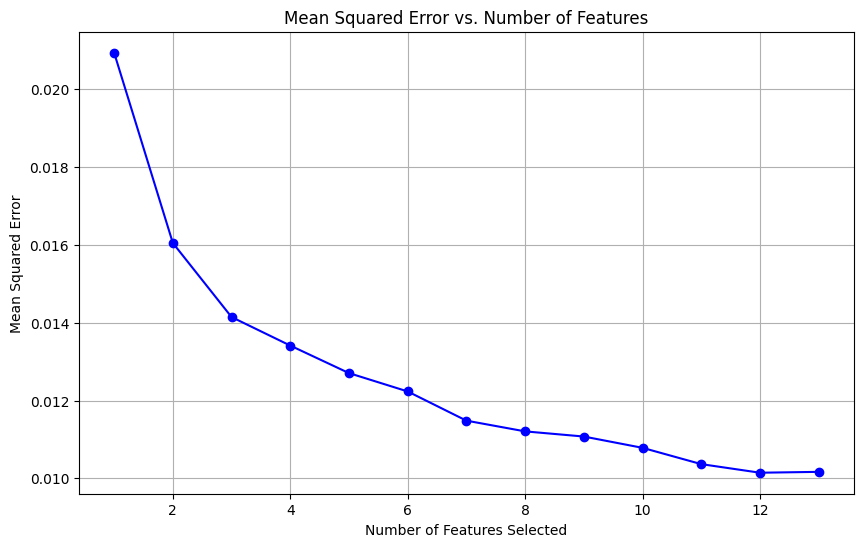

In [199]:
# Extract the mean test scores (negative MSE) and convert to positive MSE
mean_test_scores = -model_cv.cv_results_['mean_test_score']

# The number of features tested in each hyperparameter setting
n_features_to_select = [param['n_features_to_select'] for param in model_cv.cv_results_['params']]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_features_to_select, mean_test_scores, marker='o', linestyle='-', color='b')
plt.title('Mean Squared Error vs. Number of Features')
plt.xlabel('Number of Features Selected')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()


### Elbow Criterion

The **Elbow Criterion** is a heuristic for the determination of the optimal number of clusters in a data set for **k-means clustering** or the number of **Principal Components** to retain in **PCA**. The idea is to plot a curve of a relevant metric (like within-cluster sum of squares for clustering or explained variance for PCA) against the number of clusters/components. As the number of clusters/components increases, the metric typically improves up to a point, beyond which the marginal gain decreases sharply, forming an "elbow" in the plot. This point is considered optimal because it balances improvement in the metric with the complexity of the model.

While the Elbow Criterion is not directly applied in the context of RFE for selecting the number of features, the underlying principle of looking for a point of diminishing returns can be conceptually applied. For feature selection, this could translate into evaluating the model performance as a function of the number of features selected by RFE and identifying a point beyond which adding more features does not significantly improve the performance of the model.

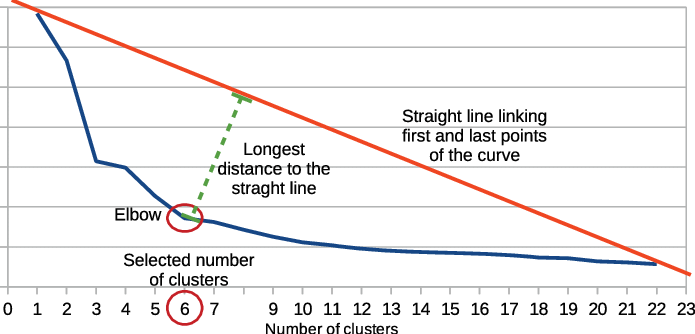

Source: "Fast Single- and Cross-Show Speaker Diarization Using Binary Key Speaker Modeling"

(https://ieeexplore.ieee.org/document/7268861)

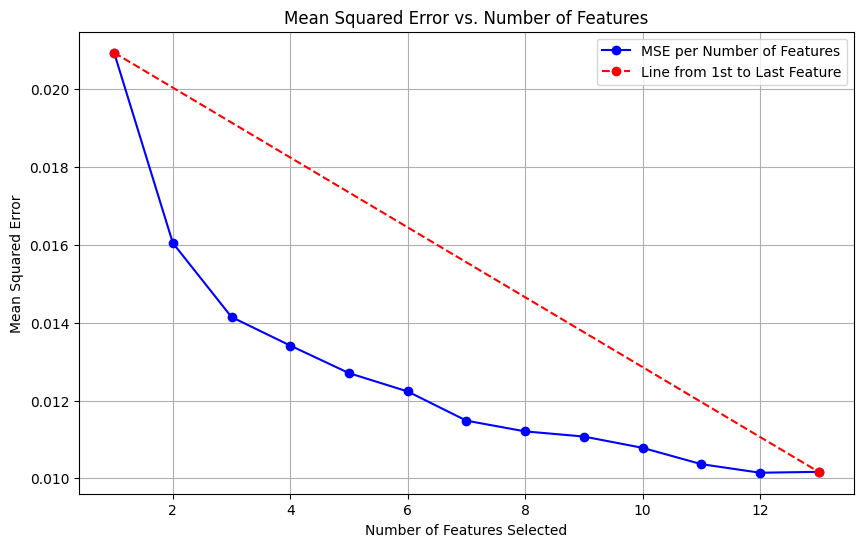

In [200]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming mean_test_scores and n_features_to_select are already defined as before

# Plotting the original MSE values
plt.figure(figsize=(10, 6))
plt.plot(n_features_to_select, mean_test_scores, marker='o', linestyle='-', color='b', label='MSE per Number of Features')

# Adding a line between the first and last point in red
plt.plot([n_features_to_select[0], n_features_to_select[-1]], [mean_test_scores[0], mean_test_scores[-1]], color='red', linestyle='--', marker='o', label='Line from 1st to Last Feature')

plt.title('Mean Squared Error vs. Number of Features')
plt.xlabel('Number of Features Selected')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.legend()
plt.show()


To compute the distance between each point, representing the Mean Squared Error (MSE) for a specific number of features, and the red line, which connects the first and last points in our plot, we use the formula for the perpendicular distance from a point to a line in a 2D plane. The formula for the distance \(d\) from a point \((x_0, y_0)\) to a line given by \(Ax + By + C = 0\) is:

$$ d = \frac{|Ax_0 + By_0 + C|}{\sqrt{A^2 + B^2}} $$

For the line segment between the first point \((x_1, y_1)\) and the last point \((x_2, y_2)\), we derive \(A\), \(B\), and \(C\) by converting the line segment equation into the general line equation format:

$$ A = y_2 - y_1 $$
$$ B = x_1 - x_2 $$
$$ C = x_2y_1 - x_1y_2 $$

Given these, we can calculate the distances for each point (representing different numbers of features and their corresponding MSE values) to this line. 


In [201]:

x1, y1 = n_features_to_select[0], mean_test_scores[0]
x2, y2 = n_features_to_select[-1], mean_test_scores[-1]

# Coefficients for the line equation
A = y2 - y1
B = x1 - x2
C = x2*y1 - x1*y2

# Calculate distances from each point to the line
distances = np.abs(A * np.array(n_features_to_select) + B * np.array(mean_test_scores) + C) / np.sqrt(A**2 + B**2)

# Create a DataFrame to display the number of features and their corresponding distances
df = pd.DataFrame({
    'Number of Features': n_features_to_select,
    'Distance to Line': distances
})

print(df)


    Number of Features  Distance to Line
0                    1          0.000000
1                    2          0.003993
2                    3          0.004998
3                    4          0.004834
4                    5          0.004644
5                    6          0.004218
6                    7          0.004070
7                    8          0.003448
8                    9          0.002683
9                   10          0.002076
10                  11          0.001597
11                  12          0.000920
12                  13          0.000000


In [202]:
# Calculate distances from each point to the line (as done previously)
# distances = np.abs(A * np.array(n_features_to_select) + B * np.array(mean_test_scores) + C) / np.sqrt(A**2 + B**2)

# Find the index of the maximum distance
max_distance_index = np.argmax(distances)

# Use this index to find the corresponding number of features
max_distance_features = n_features_to_select[max_distance_index]
max_distance_value = distances[max_distance_index]

print(f"The point with the maximum distance to the red line corresponds to {max_distance_features} features, with a distance of {max_distance_value:.4f}.")


The point with the maximum distance to the red line corresponds to 3 features, with a distance of 0.0050.


In [207]:
# final model
n_features_optimal = 3

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.42275772432923486


In [208]:

# predict prices of X_train
y_pred = rfe.predict(X_train)
r2 = sklearn.metrics.r2_score(y_train, y_pred)
print(r2)

0.5452457125784245
